In [1]:
import numpy as np
from scipy.stats import gamma, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=42)

<h3>Génération des données</h3>

<h4>La source</h4>

Supposons que les données que l'on observe soient des réalisations i.i.d. (indépendantes et identiquement distribuées) d'un triplet de variables aléatoires $(X_1,X_2,Y)$ où :
<ul>
    <li> $X_1 \sim \mathcal{N}(0,1)$, </li>
    <li> $X_2 \sim \Gamma(2,1)$, </li>
    <li> $Y = \frac{1}{2} \left( c_1 X_1 + c_2 X_2 + c_3 X_1 X_2 \right) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0,1)$.  </li>
</ul>
Le vecteur $c=(c_1,c_2,c_3)$ est un paramètre fixé à l'avance que l'on peut faire varier.

On notera $P_S(x_1,x_2,y)$ la loi du triplet $(X_1,X_2,Y)$.

<h4>La cible</h4>

On suppose que les données sur lesquelles nous souhaitons déployer notre algorithme suivent une loi de probabilité cible $P_T(x_1,x_2,y)$, déformation continue de la loi source $P_S(x_1,x_2,y)$. Pour être tout à fait précis, on suppose que $P_T$ est absoluement continue par rapport à $P_S$ et l'on note $w$ la dérivée de radon-Nikodym associée. 

De manière informelle, cela revient à supposer qu'il existe une fonction de re-pondération $w(x_1,x_2,y)$ telle que :
$$  P_T(x_1,x_2,y) = w(x_1,x_2,y) P_S(x_1,x_2,y).  $$

L'égalité ci-dessus pourra se lire " ``la probabilité d'observer (X_1=x_1,X_2=x_2,Y=y) sous la loi cible est égale à la probabilité d'observer (X_1=x_1,X_2=x_2,Y=y) sous la loi source, multipliée par le poids w(x_1,x_2,y).`` "

Dans ce qui suit, nous choisirons la fonction de re-pondération suivante :
$$ w(x_1,x_2,x_3) = \frac{1}{\mathcal{Z}} (4x_1^2 + x_2^2 + y^2), \quad \quad 
\text{avec} \, \, \,  \mathcal{Z} = \int_{ \mathbb{R}^3 } (4x_1^2 + x_2^2 + y^2) \mathrm{d} P_S(x_1,x_2,y). $$

<h4>Une approche de Monte-Carlo</h4>

Afin d'éviter les problèmes d'intégration numérique, on utilise une approche de Monte-Carlo, qui consiste à approcher les mesures de probabiltié $P_S$ et $P_T$ par des lois discrètes.

On commence par générer un ensemble de réalisations i.i.d. de la loi source à l'aide de la fonction suivante.

In [3]:
def generate_data(N, c):
    # N: integer
    # w: list/array of size 3
    # return an array of size (N, 3), each row corresponding
    # to a realization of the triplet (X_1, X_2, Y) described before
    
    x_1 = np.random.randn(N)
    x_2 = np.random.gamma(2, size=N)
    x = np.c_[x_1, x_2]

    eps = np.random.randn(N)
    y = 0.5*(c[0]*x[:, 0] + c[1]*x[:, 1] + c[2]*x[:, 0]*x[:, 1]) + eps
    
    return np.c_[x, y]

In [4]:
N_mc = int(10e5)
c = np.array([2.,0.8,1.3])
data_mc = generate_data(N_mc, c)

Notons $Z_i = (X_{1,i},X_{2,i},Y_i)$ la $i$-ème ligne du tableau data_mc. On utilise l'approximation suivante :
$$  P_S \approx \frac{1}{N_{mc}} \sum\limits_{i=1}^{N_{mc}} \delta_{Z_i}. $$
De manière informelle, cette approximation reflète le fait que l'histogramme des $Z_i$ approche la loi du triplet $(X_1,X_2,Y)$. En particulier :
<ul>
    <li> l'histogramme des $X_{1,i}$ approche la densité d'une loi normale $\mathcal{N}(0,1)$, </li>
    <li> l'histogramme des $X_{2,i}$ approche la densité d'une loi Gamma $\Gamma(2,1)$. </li>
</ul>
On illustre cette approximation avec la cellule suivante.

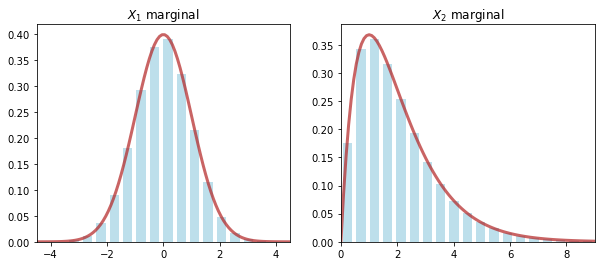

In [5]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.xlim(-4.5, 4.5)
plt.hist(data_mc[:,0], bins=20, color='lightblue', rwidth=0.7, alpha=0.8, density=True)
x = np.linspace(-4.5, 4.5, 100)
plt.plot(x, norm.pdf(x), color='firebrick', linewidth=3, alpha=0.7)
plt.title('$X_1$ marginal')

plt.subplot(1,2,2)
plt.xlim(0, 9)
plt.hist(data_mc[:,1], bins=40, color='lightblue', rwidth=0.7, alpha=0.8, density=True)
x = np.linspace(0, 9, 100)
plt.plot(x, gamma.pdf(x, 2), color='firebrick', linewidth=3, alpha=0.7)
plt.title('$X_2$ marginal')

plt.show()

On peut donc remplacer $P_S$ par la mesure ponctuelle $\frac{1}{N_{mc}} \sum\limits_{i=1}^{N_{mc}} \delta_{Z_i}$, qui consiste à choisir un $Z_i$ uniformément parmi l'ensemble $\{Z_1, \ldots, Z_{N_{mc}} \}$.

In [6]:
def proba_source(nb_samples):
    # nb_samples: integer
    # return an array of size (nb_samples, 3), each row being a
    # uniform row of the initial array data_mc
    
    idx = np.random.randint(N_mc, size=nb_samples)
    return data_mc[idx]

Pour $P_T$, c'est un peu plus compliqué et l'on omet les détails. On remplace $P_T$ par la mesure ponctuelle

$$ \sum\limits_{i=1}^N \omega_i \delta_{Z_i}, \quad \quad \text{avec} \, \, \omega_i = \frac{w\left( X_{1,i}, X_{2,i}, Y_i \right)}{\sum_{1 \leq j \leq N} w\left( X_{1,j}, X_{2,j}, Y_j \right)}.$$

Celle-ci consiste à choisir $Z_i$ parmi $\{Z_1, \ldots, Z_{N_{mn}}\}$ avec probabilité $\omega_i$.

In [7]:
w = [ 4*z[0]**2 + z[1]**2 + z[2]**2 for z in data_mc ]
omega = w / np.sum(w)

In [8]:
def proba_target(nb_samples):
    # nb_samples: integer
    # return an array of size (nb_samples, 3), each row being equal
    # to the i-th row of data_mc with probability omega_i.
    
    idx = np.random.choice(N_mc, size=nb_samples, p=omega)
    return data_mc[idx]

On peut visualiser le shift inoculé par le changement de mesure avec la cellule suivante.

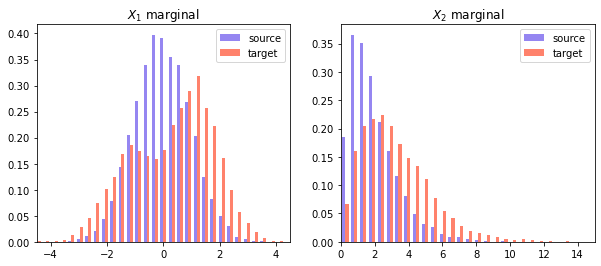

In [9]:
nb_samples = int(10e3)

data_source = proba_source(nb_samples)
data_target = proba_target(nb_samples) 

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.xlim(-4.5, 4.5)
#plt.hist(data_source[:,0], bins=18, color='mediumslateblue', rwidth=0.7, alpha=0.8, density=True, label='source')
#plt.hist(data_target[:,0], bins=20, color='tomato', rwidth=0.7, alpha=0.8, density=True, label='target')
plt.hist([data_source[:,0],data_target[:,0]], 
         bins=30, color=['mediumslateblue','tomato'], 
         rwidth=0.7, alpha=0.8, density=True, label=['source','target'])
plt.legend(loc='best')
plt.title('$X_1$ marginal')

plt.subplot(1,2,2)
plt.xlim(0, 15)
#plt.hist(data_source[:,1], bins=18, color='mediumslateblue', rwidth=0.7, alpha=0.8, density=True, label='source')
#plt.hist(data_target[:,1], bins=20, color='tomato', rwidth=0.7, alpha=0.8, density=True, label='target')
plt.hist([data_source[:,1],data_target[:,1]], 
         bins=30, color=['mediumslateblue','tomato'], 
         rwidth=0.7, alpha=0.8, density=True, label=['source','target'])
plt.legend(loc='best')
plt.title('$X_2$ marginal')

plt.show()

<h3>Re-pondération des données sources</h3>

En pratique, on observe uniquement des données sous la loi source $P_S$ et *aucune* sous la loi cible $P_T$. En revanche, on a parfois accès à de l'information auxiliaire sur la loi $P_T$. Dans ce qui suit, on suppose que l'on connaît la moyenne de $X_1$ et de $X_2$ sous la loi cible. Comme dans ce qui précède, on approxime ces moyennes à l'aide de la méthode de Monte-Carlo :
$$ \mathbb{E}_{P_T}[X_1] \approx \sum\limits_{i=1}^{N_{mc}} \omega_i X_1^{(i)} \quad \quad \text{et} 
\quad \quad  \mathbb{E}_{P_T}[X_2] \approx \sum\limits_{i=1}^{N_{mc}} \omega_i X_2^{(i)}.$$
On calcule ces quantités dans la cellule suivante. 

In [10]:
idx = np.random.choice(N_mc, N_mc, p=omega)
z_t = data_mc[idx]

mu = np.zeros(3)
mu[0] = 1
mu[1] = z_t[:,0].mean()
mu[2] = z_t[:,1].mean()

In [11]:
mu[1], mu[2]

(0.2565809546628422, 3.1912108020851933)

<font color='red'>Attention :</font> Pour simuler nos données, nous avons utilisé la connaissance des coeficients de re-pondération $\omega_i$. Nous allons désormais devenir amnésique et essayer de retrouver ces coefficients à partir de la connaissance :
<ul>
    <li> des données sources (data_source), que l'on note $Z^{S}_i = (X^{S}_{1,i}, X^{S}_{2,i}, Y^{S}_i)$, $i=1, \ldots, n = \text{nb_samples}$ ; </li>
    <li> d'une hypothèse paramétrique sur la fonction $w(x_1,x_2,y)$ ; </li>
    <li> de l'information auxiliaire $\mathbb{E}_{P_T}[X_1] = \mu_1$ et $\mathbb{E}_{P_T}[X_2] = \mu_2$.</li>    
</ul>
Pour simplifier notre propos, nous supposons que la fonction $\omega$ est de la forme
$$ \omega_\alpha(x_1,x_2,y) =  \alpha_1^2x_1^2 + 4 \alpha_2^2 x_2^2 + 2 \alpha_3^2 y^2 = \alpha^T \mathrm{Diag}(x_1^2, 4x_2^2, 2 y^2) \alpha ,$$
pour un certain vecteur $\alpha = (\alpha_1, \alpha_2, \alpha_3)$. 


Le but est de trouver le coefficient $\alpha$ satisfaisant au mieux les contraintes du problème. Pour cela, on cherche à minimiser la fonction d'erreur
$$ \Psi_n(\alpha) = \left( \frac{1}{n} \sum\limits_{i=1}^{n} w_\alpha( Z_i^{S} )  - 1 \right)^2
                  + \left( \frac{1}{n} \sum\limits_{i=1}^{n} w_\alpha( Z_i^{S} ) X^{S}_{1,i} - \mu_1  \right)^2
                  + \left( \frac{1}{n} \sum\limits_{i=1}^{n} w_\alpha( Z_i^{S} ) X^{S}_{2,i} - \mu_2  \right)^2 .$$
                  
Le premier terme permet de prendre en compte le fait que les $\omega_i$ correspondent peu ou prou à une mesure de probabilité.

In [12]:
def psi_emp(alpha):
    w_alpha = np.array([ alpha[0]**2 * z[0]**2 + alpha[1]**2 * z[1]**2 + alpha[2]**2 * z[2]**2 for z in data_source ]) 
    omega_alpha = w_alpha / np.sum(w_alpha)
    term0 = np.mean( omega_alpha )
    term1 = np.mean( omega_alpha.T @ data_source[:,0] )
    term2 = np.mean( omega_alpha.T @ data_source[:,1] )
    return (term0 - mu[0])**2 + (term1 - mu[1])**2 + (term2 - mu[2])**2

On exploite le module optimize de scipy et on utilise plusieurs points d'initialisation afin d'estimer $\alpha$ dans la cellule qui suit.

In [13]:
alpha_est = []
psi_emp_est = []
for b in range(1):
    res = minimize(psi_emp, np.random.randn(3), method='BFGS')
    alpha_est.append(np.abs(res.x))
    psi_emp_est.append(psi_emp(res.x))
idx = np.argmin(psi_emp_est)
alpha_emp = alpha_est[idx]
alpha_emp

array([2.2970449 , 1.20640381, 1.15811471])

In [14]:
weight_emp = np.array([ alpha_emp[0]**2 * z[0]**2 + alpha_emp[1]**2 * z[1]**2 + alpha_emp[2]**2 * z[2]**2 for z in data_source ]) 

In [15]:
X_S, y_S = data_source[:,:2], data_source[:,2]
X_T, y_T = data_target[:,:2], data_target[:,2]

In [16]:
Z_test = proba_target(int(nb_samples/20)) 
X_test, y_test = Z_test[:,:2], Z_test[:,2]

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [18]:
lin1 = LinearRegression()
lin1.fit(X_S, y_S, weight_emp)
y_pred_1 = lin1.predict(X_test)

lin2 = LinearRegression()
lin2.fit(X_T, y_T, weight_emp)
y_pred_2 = lin2.predict(X_test)

lin3 = LinearRegression()
lin3.fit(X_S,y_S)
y_pred_3 = lin3.predict(X_test)

mse1 = mean_squared_error(y_test,y_pred_1)
mse2 = mean_squared_error(y_test,y_pred_2)
mse3 = mean_squared_error(y_test,y_pred_3)

print(mse1, mse2, mse3)

3.953898811942576 3.9416020921617565 5.425933223397712


<h4>Observation de la re-pondération</h4>

In [19]:
def reweighted_prob(nb_samples, data, weights):
    idx = np.random.choice(data.shape[0], size=nb_samples, p=weights/np.sum(weights))
    return data[idx]

In [20]:
weights = weight_emp / np.sum(weight_emp)

In [21]:
N = data_source.shape[0]
X_reweighted = reweighted_prob(N, data_source, weights)

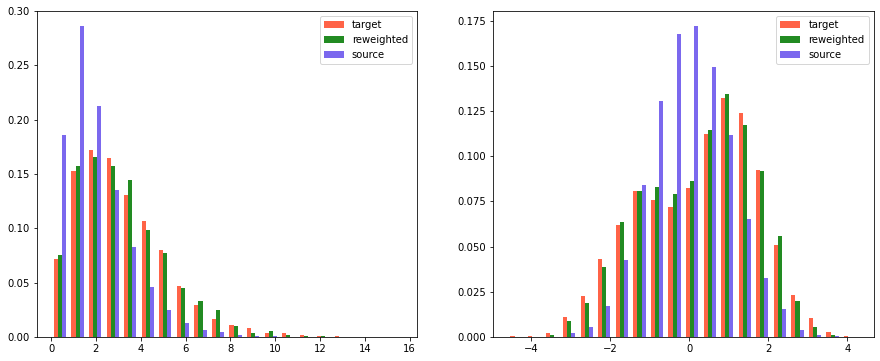

In [22]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist([X_T[:,1], X_reweighted[:,1], X_S[:,1]], bins=20, color=['tomato', 'forestgreen', 'mediumslateblue'], rwidth=0.7, 
        weights=[(1/N)*np.ones(N), (1/N)*np.ones(N), (1/N)*np.ones(N)],
        label=['target', 'reweighted', 'source'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist([X_T[:,0], X_reweighted[:,0], X_S[:,0]], bins=20, color=['tomato', 'forestgreen', 'mediumslateblue'], rwidth=0.7, 
        weights=[(1/N)*np.ones(N), (1/N)*np.ones(N), (1/N)*np.ones(N)],
        label=['target', 'reweighted', 'source'])
plt.legend(loc='best')

plt.show()